In [2]:
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from model import Net
from preprocessor import CorpusPreprocessor
from dataset import CorpusDataset

In [3]:
DATA_FILE = 'corpus.pt'
MODEL_FILE = 'checkpoint.pt'
DEVICE = 'cuda:0'

cp = CorpusPreprocessor()
cp.load(DATA_FILE)
_, dataset = CorpusDataset.split(cp, 0.8)

net = Net(len(cp.alphabet), cp.max_sentence_length, cp.max_word_length)
net.load_state_dict(torch.load(MODEL_FILE, map_location=DEVICE))
net.to(DEVICE)
we = net.we

Obliczmy embeddingi dla wszystkich słów:

In [4]:
embs = dict()
for w in cp.words:
    with torch.no_grad():
        t = dataset.word2tensor(w).to(DEVICE).unsqueeze(0)
        embs[w] = we(t).squeeze(0).cpu()

## Podobne słowa
Znajdźmy słowa najbardziej podobne do wybranych (najbliższe w sensie odległości w przestrzeni)

In [5]:
mywords = ['komputer', 'kot', 'piłka', 'samochód', 'kobieta', 'ciasto', 'pieniądze']

for mw in mywords:
    print(mw)
    dists = []
    for w in cp.words:
        if w == mw:
            continue
        dist = torch.sqrt(torch.sum((embs[mw] - embs[w]) ** 2)).item()
        dists.append((w, dist))
    dists = sorted(dists, key=lambda x: x[1])
    for w, d in dists[:20]:
        print('  ', w, d)

komputer
   komputera 0.8361257314682007
   komputerów 0.937332034111023
   computer 1.0007460117340088
   komputery 1.0572911500930786
   dorpater 1.2310502529144287
   kończyły 1.2502671480178833
   komputerze 1.2542715072631836
   komputerach 1.286967158317566
   woltyżer 1.2961187362670898
   komputerków 1.3147214651107788
   kostrzeba 1.330984115600586
   kolejność 1.3393135070800781
   kiszonej 1.3459151983261108
   kończyła 1.348572850227356
   kondzior 1.3541357517242432
   kompresji 1.359271764755249
   konojady 1.3657888174057007
   rowzniez 1.3750306367874146
   kolding 1.376708745956421
   merziger 1.3833073377609253
kot
   lot 1.2404721975326538
   kop 1.2830448150634766
   kolo 1.2875198125839233
   kota 1.3060840368270874
   kotó 1.379676103591919
   wil 1.3852486610412598
   koty 1.3895745277404785
   korą 1.3934481143951416
   miza 1.4214236736297607
   kotu 1.432337760925293
   mors 1.4420522451400757
   moto 1.4422756433486938
   mor 1.458944320678711
   morę 1.45979

## Relacje semantyczne

In [15]:
testpairs = [
    ('warszawa', 'polska', 'paryż', 'francja'),
    ('niemcy', 'berlin', 'rosja', 'moskwa'),
    ('stół', 'stołu', 'dom', 'domu'),
    ('król', 'mężczyzna', 'królowa', 'kobieta'),
    ('tata', 'mężczyzna', 'mama', 'kobieta'),
    ('on', 'mężczyzna', 'ona', 'kobieta'),
    ('ciepło', 'lato', 'zimno', 'zima'),
    ('ciemno', 'noc', 'jasno', 'dzień'),
    ('samochód', 'koła', 'samolot', 'skrzydła'),
    ('ojciec', 'mężczyzna', 'jezioro', 'ciasto'),
    ('pis', 'kaczyński', 'po', 'tusk'),
    ('samochód', 'samochodem', 'rower', 'roweru'),
    ('samochód', 'samochodem', 'rower', 'rowerem'),
    ('ciasto', 'ciasta', 'kobieta', 'kobiety'),
]

testwords = list({w for doublepair in testpairs for w in doublepair})

dists = []

for pair in testpairs:
    dist = torch.sqrt(torch.sum(((embs[pair[0]] - embs[pair[1]]) - (embs[pair[2]] - embs[pair[3]])) ** 2)).item()
    dists.append((pair, dist))

for pair, dist in sorted(dists, key=lambda p: p[1]):
    print(f'W({pair[0]:^10}) - W({pair[1]:^10}) ≃ W({pair[2]:^10}) - W({pair[3]:^10}) : {dist}')

W(  ciasto  ) - W(  ciasta  ) ≃ W( kobieta  ) - W( kobiety  ) : 1.626247763633728
W( samochód ) - W(samochodem) ≃ W(  rower   ) - W( rowerem  ) : 1.7039401531219482
W( samochód ) - W(samochodem) ≃ W(  rower   ) - W(  roweru  ) : 1.8858426809310913
W(   stół   ) - W(  stołu   ) ≃ W(   dom    ) - W(   domu   ) : 2.546475887298584
W(   tata   ) - W(mężczyzna ) ≃ W(   mama   ) - W( kobieta  ) : 2.6872739791870117
W( samochód ) - W(   koła   ) ≃ W( samolot  ) - W( skrzydła ) : 3.6576640605926514
W(  ciemno  ) - W(   noc    ) ≃ W(  jasno   ) - W(  dzień   ) : 3.813601493835449
W(  niemcy  ) - W(  berlin  ) ≃ W(  rosja   ) - W(  moskwa  ) : 3.962707042694092
W(  ciepło  ) - W(   lato   ) ≃ W(  zimno   ) - W(   zima   ) : 4.317355632781982
W(   król   ) - W(mężczyzna ) ≃ W( królowa  ) - W( kobieta  ) : 4.789261341094971
W(  ojciec  ) - W(mężczyzna ) ≃ W( jezioro  ) - W(  ciasto  ) : 5.015779972076416
W(    on    ) - W(mężczyzna ) ≃ W(   ona    ) - W( kobieta  ) : 5.547707557678223
W( warszawa 

## Wizualizacja

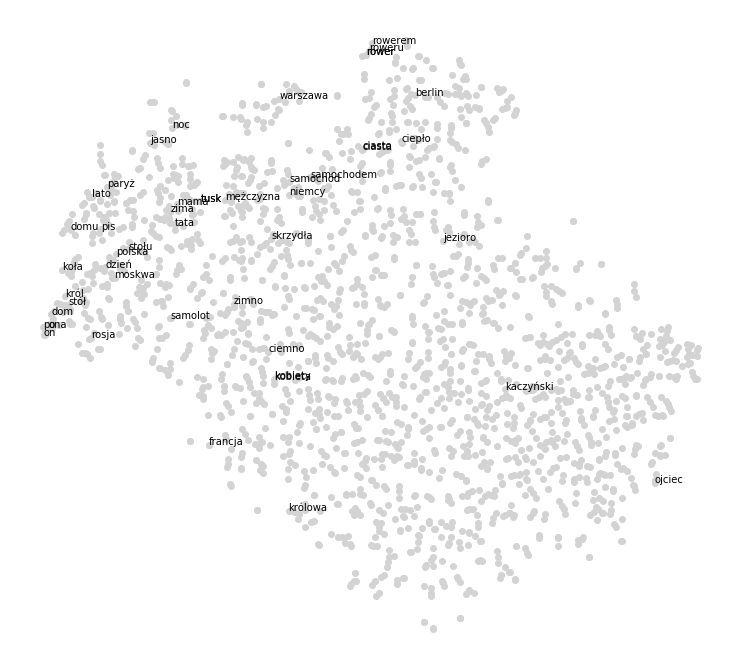

In [17]:
words = testwords + random.sample(cp.words, 2000)
tsne = TSNE(perplexity=15, n_components=2).fit_transform(torch.stack(tuple(embs[w] for w in words)).numpy())

plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0)

xs = list(tsne[:, 0])
ys = list(tsne[:, 1])
plt.scatter(xs, ys, c='lightgrey')
for x, y, w in zip(xs, ys, words):
    if w in testwords:
        ax.annotate(w, (x, y))